I'm working on implementing the generative model here

In [1]:
import torch
import pennylane as qml
from itertools import combinations
from time_series_utils import generate_normal_time_series_set, plot_series

In [2]:
def D(gamma: torch.Tensor, start : int, stop : int, h: int = None, get_probs: bool = False) -> None:
    """Generates an n_qubit quantum circuit according to a h-local Walsh operator
    expansion. Here, h-local means that 1 <= k <= n of the n qubits can interact.
    See <https://doi.org/10.1088/1367-2630/16/3/033040> for more
    details. Optionally return probabilities of bit strings.
    """
    if h is None:
        h = stop - start
    cnt = 0
    for i in range(1, h + 1):
        for comb in combinations(range(start, stop), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(start, stop))

In [3]:
from time_series_utils import apply_sax


series_length = 5
n_subspace_qubits = 2
environment_qubits = n_subspace_qubits
dev = qml.device("default.qubit", wires= series_length*n_subspace_qubits + environment_qubits, shots=None)
#X_norm, T_norm = generate_normal_time_series_set(25, 25, 0.1, 0.1, 2 * torch.pi)
#plot_series(T_norm, X_norm)
# Make time series discrete using SAX
#discrete_X = apply_sax(X_norm, n_sax_symbols = 2**n_subspace_qubits)
#discrete_T = apply_sax(T_norm, n_sax_symbols = 2**n_subspace_qubits)
#plot_series(discrete_T, discrete_X)


In [4]:
# Now X = (s_1, ..., s_m) where each s_i is a discrete time series
# Depending on the discretization, we use x subspace qubits to encode space H_s_i
@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(
    X: torch.Tensor,
    t: float,
    n_subspace_qubits: int,
    environment_qubits: int,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    h: int,
    W: callable,
    D: callable,
    n_qubits: int,
    measurement: str
) -> torch.Tensor:
        
    # Depending on the dimensionality of the input, 
    # we need to embed the time series data
    # into different subspaces
    for i, point in enumerate(X):
        subspace = range(i*n_subspace_qubits, (i + 1)*n_subspace_qubits)
        x_t = point[t]
        qml.BasisEmbedding(x_t, wires=subspace)
    
        # These gates operate h-locally
        # This means that each time series component corresponding
        # a subspsace H_s_d is evolved with its own decomposition WDW^t
    
        W(alpha, wires=subspace)
        D(gamma * t, i*n_subspace_qubits, (i + 1)*n_subspace_qubits, h)
        qml.adjoint(W)(alpha, wires=subspace)
    
    # Finally, create environment subspace
    e_subspace = range(n_qubits - environment_qubits, n_qubits)
    W(alpha, wires=e_subspace)
    D(gamma * t, n_qubits - environment_qubits, n_qubits, h)
    qml.adjoint(W)(alpha, wires=e_subspace)
    
    if measurement == "probs":
        return qml.probs(range(n_qubits))
    elif measurement == "density_matrix":
        return qml.density_matrix(range(n_qubits))
    elif measurement == "state":
        return qml.state()

In [5]:
def quantum_transition_matrix(probs, n_subspace_qubits, dimension_of_time_series):
    """Computes the quantum transition matrix from the probability distribution
    of the quantum state.
    """
    subspace_probs = {}
    for i in range(dimension_of_time_series):
        subspace_probs[i] = probs[i*n_subspace_qubits:(i + 1)*n_subspace_qubits]
    print(subspace_probs)
    return subspace_probs

In [6]:
def KL_divergence(p, q):
    """Computes the KL divergence between two probability distributions.
    """
    if torch.all(q) == 0:
        return 0
    return torch.sum(p * torch.log(p / q))

In [7]:
def total_KL_divergence(X, time_steps, classical_transition_matrix, quantum_transition_matrix):
    total_kl_div = 0
    for t in time_steps:
        for d in range(len(X)):
            total_kl_div += KL_divergence(classical_transition_matrix[t][d], quantum_transition_matrix[t][d])

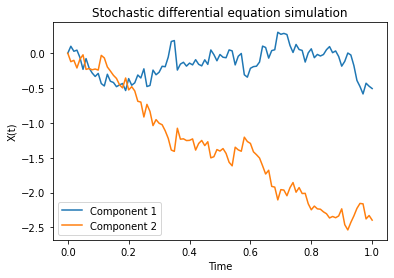

In [8]:
from time_series_utils import generate_synthetic_correlated_time_series
import matplotlib.pyplot as plt
import numpy as np

X = generate_synthetic_correlated_time_series()
# Plotting
time = np.linspace(0, 1, 101)
for i in range(2):
    plt.plot(time, X[i], label=f'Component {i+1}')

plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Stochastic differential equation simulation')
plt.legend()
plt.show()

In [10]:
discrete_X = apply_sax(X, n_sax_symbols = 2**n_subspace_qubits)
print(discrete_X)


Sax time series: [[[0]
  [1]
  [2]
  [2]]

 [[3]
  [2]
  [1]
  [0]]]
[[array(['0000'], dtype='<U4'), array(['0001'], dtype='<U4'), array(['0010'], dtype='<U4'), array(['0010'], dtype='<U4')], [array(['0011'], dtype='<U4'), array(['0010'], dtype='<U4'), array(['0001'], dtype='<U4'), array(['0000'], dtype='<U4')]]


ValueError: Expected 2D array, got 1D array instead:
array=[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.